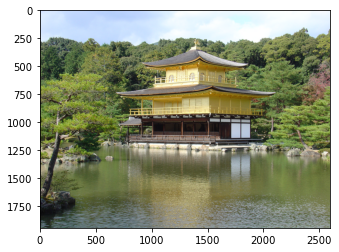

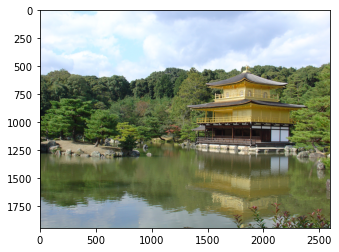

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pymagsac
from time import time

img1 = cv2.cvtColor(cv2.imread('../data/fundamental_matrix/KyotoA.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../data/fundamental_matrix/KyotoB.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [16]:
#We will detect ORB features and match them with cross-check test
det = cv2.ORB_create(1000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

tentatives = bf.match(descs1,descs2)

In [17]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [18]:
img1.shape

(1944, 2592, 3)

Note that the inlier number does not determine the quality of the solution since MAGSAC and MAGSAC++ does not return inliers. The ones shown are selected by using a dummy threshold.
61.0 inliers found
0.018947839736938477 sec cv2
171.0 inliers found
0.017952680587768555  sec magsac++
174.0 inliers found
0.012964963912963867  sec magsac


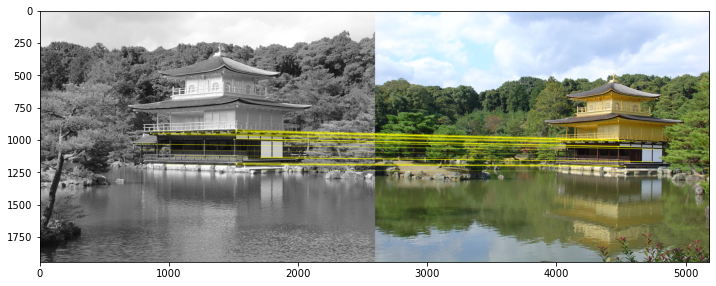

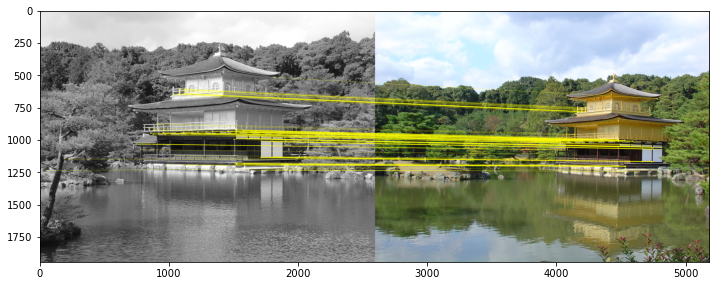

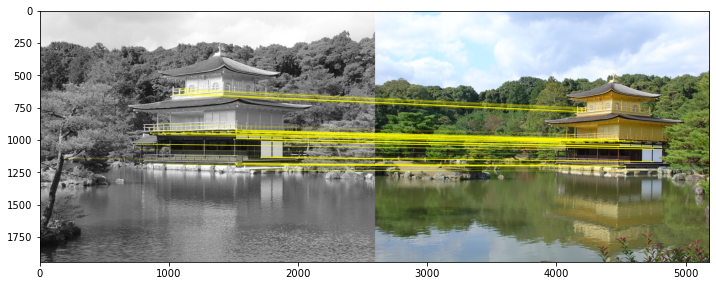

In [19]:
def verify_cv2_fundam(kps1, kps2, tentatives):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,1,2)
    H, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC, 0.75)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

def verify_pymagsac_fundam(kps1, kps2, tentatives, use_magsac_plus_plus):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    H, mask = pymagsac.findFundamentalMatrix(
        np.ascontiguousarray(src_pts), 
        np.ascontiguousarray(dst_pts), 
        use_magsac_plus_plus = use_magsac_plus_plus,
        sigma_th = 3.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

print("Note that the inlier number does not determine the quality of the solution since MAGSAC and MAGSAC++ does not return inliers. The ones shown are selected by using a dummy threshold.")

t=time()
cv2_F, cv2_mask = verify_cv2_fundam(kps1,kps2,tentatives)
print (time()-t, 'sec cv2')

t=time()
magpp_F, magpp_mask = verify_pymagsac_fundam(kps1, kps2, tentatives, True)
print (time()-t, ' sec magsac++')

t=time()
mag_F, mag_mask = verify_pymagsac_fundam(kps1, kps2, tentatives, False)
print (time()-t, ' sec magsac')

draw_matches(kps1, kps2, tentatives, img1, img2, cv2_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, mag_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, magpp_mask)

Note: the number of inliers does not determine the quality of the solution. 
    This adaptive inlier selection algorithm selects the set of inliers such that they lead 
    to the most similar model after LSQ fitting to the estimated one.
    This might be useful e.g. in SfM pipelines when using MAGSAC or MAGSAC++.
    If more inliers are needed, parameter 'minimum_required_inliers' should be set higher
126 inliers are found by the adaptive strategy
1.0562112807070472 px is the best threshold


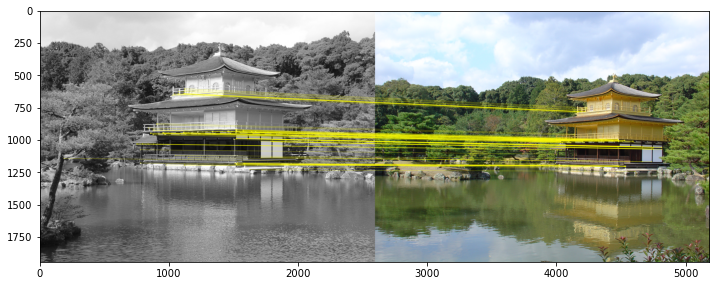

In [20]:
def adaptive_inlier_selection(kps1, kps2, tentatives, model, maximum_threshold, minimum_required_inliers):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    
    mask, inlier_number, best_threshold = pymagsac.adaptiveInlierSelection(
        np.ascontiguousarray(src_pts), 
        np.ascontiguousarray(dst_pts), 
        np.ascontiguousarray(model), 
        maximumThreshold = maximum_threshold, # An upper bound for the threshold, this speeds up the procedure, but it should work with infinity as well
        problemType = 1, # 1 stands for fundamental matrix fitting
        minimumInlierNumber = minimum_required_inliers)
    
    return mask, inlier_number, best_threshold

mask, inlier_number, best_threshold = adaptive_inlier_selection(kps1, kps2, tentatives, magpp_F, 10.0, 20)
draw_matches(kps1, kps2, tentatives, img1, img2, mask)

print("""Note: the number of inliers does not determine the quality of the solution. 
    This adaptive inlier selection algorithm selects the set of inliers such that they lead 
    to the most similar model after LSQ fitting to the estimated one.
    This might be useful e.g. in SfM pipelines when using MAGSAC or MAGSAC++.
    If more inliers are needed, parameter 'minimum_required_inliers' should be set higher""")
print(inlier_number, 'inliers are found by the adaptive strategy')
print(best_threshold, 'px is the best threshold')